### Starbucks Capstone Challenge

### 1.Business understanding

I have choosen to use the Starbucks rewards mobile app simulated database in order to analyze the customers behaviour. This project is as part of the Data Science Nanodegree program offered by Udacity.

In order to complete this project I have used the CRISP-DM method.

The main purpose of this project is to offer a specific analysis over the Starbucks market by answering the following questions:

### Questions

##### Starbucks offers  
* What type of offers does Starbucks provide?
* What is the minimum and maximum reward associated with an offer?
* What is the average duration and difficulty for an offer depending on their characteristics?
* Which channels are mainly preffered in promoting offers?

##### Customers profile 
* What are the main demographic characterizes for Starbucks typical customers?
* What is the customer average income by offer type?
* What type of events are preffered by customers taking into perspective the age, gender and income?


##### Events    
* What are the proportions associated with each event type?
* What is the average time needed to complete an offer?
* How can we describe the Starbucks customer behavior?
* Can we predict the how much someone will spend based on customer characteristics and offer eligibility?
* What are the main variables that influence the decision of a customer to respond to an offer?

### 2. Data understanding 

#### Import libraries

In [182]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import re
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, r2_score, mean_squared_error, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore') 
% matplotlib inline


#from sqlalchemy import create_engine
#from nltk.tokenize import word_tokenize, sent_tokenize
#from nltk import pos_tag, ne_chunk
#from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
#from nltk.stem.wordnet import WordNetLemmatizer
#from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer
#from sklearn.base import BaseEstimator,TransformerMixin
#from sklearn.svm import LinearSVC
#from sklearn.neighbors import KNeighborsClassifier


#### Load data 
* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [183]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Offers dataframe 

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [151]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [152]:
# number of offer ids 
print('There are:', len(portfolio['id'].unique()), 'unique offers.')

There are: 10 unique offers.


##### What type of offers does Starbucks provide?

In [153]:
#https://stackoverflow.com/questions/66940757/pandas-list-in-column-to-binary-column
portfolio_split = portfolio['channels'].str.join('|').str.get_dummies() 
portfolio_split = pd.concat([portfolio, portfolio_split], axis=1)
portfolio_split

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [154]:
print('There are', len(pd.unique(portfolio['offer_type'])), 'types of offers:',portfolio['offer_type'].unique())

There are 3 types of offers: ['bogo' 'informational' 'discount']


In [155]:
#define a pie plot function
def pieplot_draw(var, df, colors, title, ylabel):
    values = var.value_counts()
    (values/df.shape[0]).plot(kind='pie', autopct='%.1f', colors = colors)
    plt.title(title)
    plt.ylabel(ylabel)

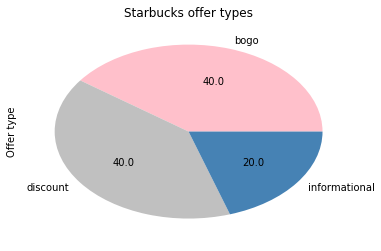

In [156]:
pieplot_draw(portfolio['offer_type'], portfolio, ['pink', 'silver', 'steelblue'], "Starbucks offer types", 'Offer type'); 

Accordingly to the above chart,  40% of offers are categorised as discount, other 40% as bogo and the remaining of 20% is considered informational. 

##### What is the minimum and maximum reward associated with an offer?

In [157]:
def min_value(var, df):
    return df[var].min()

def max_value(var, df):
    return df[var].max()

def mode_value(var, df):
    return df[var].mode()

def avg_value(var, df):
    return df[var].mean()

def category(df, var_by, var_to):
    return pd.DataFrame(df.groupby(var_by).mean()[var_to].round())

In [158]:
print('The minimum reward is ', min_value('reward', portfolio), '.')
print('The maximum reward is ', max_value('reward', portfolio), '.')
print('The average reward is ', avg_value('reward', portfolio), '.')

The minimum reward is  0 .
The maximum reward is  10 .
The average reward is  4.2 .


In [159]:
category(portfolio, 'offer_type', 'reward')

,reward
offer_type,
bogo,8.0
discount,3.0
informational,0.0


The bogo offers have an average reward of 8, the discount offers have a smaller reward of 3, while informational offers do not offer any reward.

##### What is the average duration and difficulty for an offer depending on their characteristics?

In [13]:
#define a bar plot function 
def barplot_draw(var, df, color, title, ylabel, xlabel):
    values = var.value_counts()
    (values/df.shape[0]).plot(kind='bar', color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

In [14]:
print('The average duration of an offer is ', avg_value('duration', portfolio), '.')

The average duration of an offer is  6.5 .


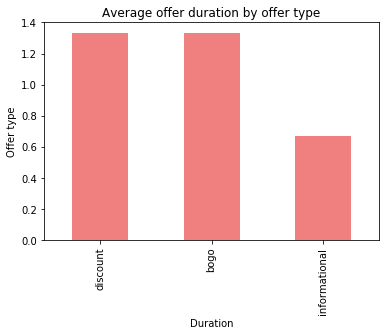

In [21]:
barplot_draw(portfolio['offer_type'], category(portfolio, 'offer_type', 'duration'), 'lightcoral', "Average offer duration by offer type", 'Offer type', 'Duration')

In [183]:
print('The average difficulty of an offer is ', avg_value('difficulty', portfolio), '.')

The average difficulty of an offer is  7.7 .


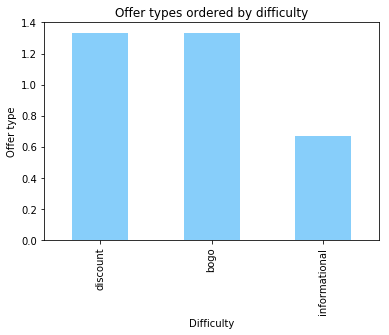

In [28]:
barplot_draw(portfolio['offer_type'], category(portfolio, 'offer_type', 'difficulty'), 'lightskyblue', "Offer types ordered by difficulty", 'Offer type', 'Difficulty')

#####  Which channels are mainly prefered in promoting offers?

In [184]:
def count_dummy(var, df):
    var_aux = (df[var].values == 1).sum()
    return var_aux

In [22]:
aux = [['mobile', count_dummy('mobile', portfolio_split)], ['email', count_dummy('email', portfolio_split)], ['social', count_dummy('social', portfolio_split)], ['web', count_dummy('web', portfolio_split)]]
df_aux = pd.DataFrame(aux, columns = ['Channels', 'Offers'])
df_aux

,Channels,Offers
0,mobile,9
1,email,10
2,social,6
3,web,8


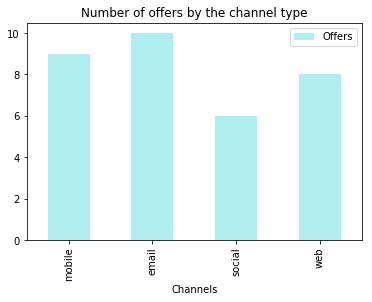

In [23]:
df_aux.plot.bar(x = 'Channels', y = ['Offers'], title= 'Number of offers by the channel type', color='paleturquoise')

Most offers are transmited through email and mobile, but there are also offers send by web and social channels. 

### Customers dataframe 

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [24]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [25]:
# number of customer ids
print('There are:', len(profile['id'].unique()), 'unique customers.')

There are: 17000 unique customers.


#####  What are the main demographic characterists for Starbucks typical customers?

In [26]:
print('The minimum age is ', min_value('age', profile), 'years.')
print('The maximum age is ', max_value('age', profile), 'years.')
print('The average age is ', avg_value('age', profile).round(), 'years.')

The minimum age is  18 years.
The maximum age is  118 years.
The average age is  63.0 years.


From analyzing the profile data, in average a typical customer is assumed to have 63 years. However the maximum age is 118 years, so in a further step we will be analyzing the extreme values hypothesis.

In [27]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

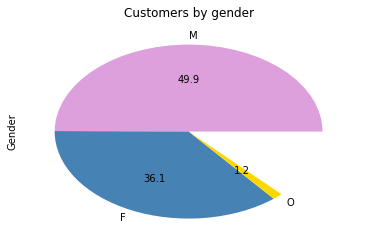

In [28]:
pieplot_draw(profile['gender'], profile, ['plum', 'steelblue', 'gold'], "Customers by gender", 'Gender'); 

As can be seen from the above representation, the majority of Starbucks customers are represented by mens by approximative 49.9%, the womens representing only 36.1%

##### What is the customer average income?

In [29]:
print('The minimum income is ', min_value('income', profile), 'monetary units.')
print('The maximum income is ', max_value('income', profile), 'monetary units.')
print('The average income is ', avg_value('income', profile).round(), 'monetary units.')

The minimum income is  30000.0 monetary units.
The maximum income is  120000.0 monetary units.
The average income is  65405.0 monetary units.


In [30]:
category(profile, 'gender', 'income')

,income
gender,
F,71306.0
M,61195.0
O,63288.0


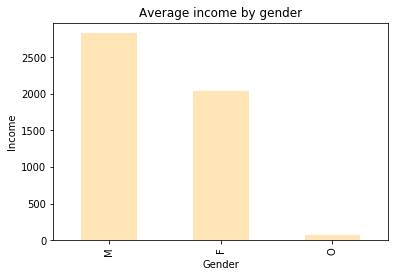

In [31]:
barplot_draw(profile['gender'], category(profile, 'gender', 'income'), 'moccasin', "Average income by gender", 'Income', 'Gender')

As we can see there is a discrepancy associated with income when grouping by gender.

### Events dataframe

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [32]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


##### What are the proportions associated with each event type?

In [33]:
print('There are', transcript['person'].value_counts().sum(), 'non-unique customers where',transcript['event'].value_counts()['transaction'], 'made a transaction,', transcript['event'].value_counts()['offer completed'], 'have completed the offer,', transcript['event'].value_counts()['offer viewed'], 'have only viewed the offer, meanwhile', transcript['event'].value_counts()['offer received'], 'have received it, but did not take any action.')

There are 306534 non-unique customers where 138953 made a transaction, 33579 have completed the offer, 57725 have only viewed the offer, meanwhile 76277 have received it, but did not take any action.


In [34]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

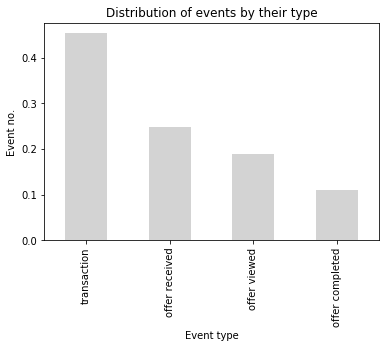

In [35]:
barplot_draw(transcript['event'], transcript, 'lightgray', "Distribution of events by their type", 'Event no.', 'Event type')

##### What is the average time needed to complete an offer?

In [36]:
category(transcript, 'event', 'time')

,time
event,
offer completed,401.0
offer received,333.0
offer viewed,354.0
transaction,382.0


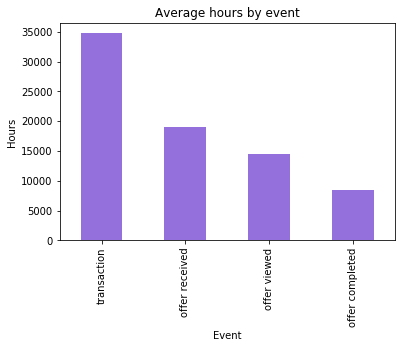

In [37]:
barplot_draw(transcript['event'], category(transcript, 'event', 'time'), 'mediumpurple', "Average hours by event", 'Hours', 'Event')

As we can see the time to complete an offer is increasing proportionally with each step of the offer.

In [38]:
print('The average number of hours required for an offer is ', avg_value('time', transcript).round(1), 'hours, meaning', (avg_value('time', transcript)/24).round(),'days.')

The average number of hours required for an offer is  366.4 hours, meaning 15.0 days.


### 3. Data preparation 

### Test for null values 

In [185]:
def check_null(df):
    return df.isnull().sum()

##### A. Offers dataframe

In [40]:
# Check the null values for the profile dataframe
check_null(portfolio)

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [41]:
print('There are', check_null(portfolio).sum(), 'missing values in the portfolio df.')

There are 0 missing values in the portfolio df.


##### B. Customers dataframe

In [42]:
# Check the null values for the profile dataframe
check_null(profile)

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [43]:
(check_null(profile)/profile.shape[0]).round(2)

age                 0.00
became_member_on    0.00
gender              0.13
id                  0.00
income              0.13
dtype: float64

The missing values represent only 13% of the data so we will drop the NA values.  

In [186]:
# Show the number of rows and columns 
print('Profile file shape before cleaning: ', profile.shape[0], 'rows and', profile.shape[1], 'columns.')
#dropping missing data from profile df
profile = profile.dropna(subset=['gender', 'income'])
print('Profile file shape after cleaning: ', profile.shape[0], 'rows and', profile.shape[1], 'columns.')

Profile file shape before cleaning:  17000 rows and 5 columns.
Profile file shape after cleaning:  14825 rows and 5 columns.


In [45]:
# Check the null values for the profile dataframe
print('There are', check_null(profile).sum(), 'missing values in the profile df.')

There are 0 missing values in the profile df.


##### C. Events dataframe

In [46]:
# Check the null values for the profile dataframe
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [47]:
print('There are', check_null(transcript).sum(), 'missing values in the transcript df.')

There are 0 missing values in the transcript df.


### Check for extreme values 

##### A. Offer dataframe

In [48]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


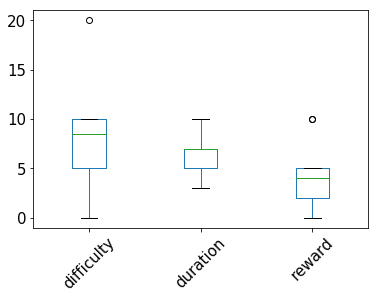

In [49]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html
portfolio.boxplot(grid=False, rot=45, fontsize=15)  

There are some extreme values for the columns difficulty and reward.

In [187]:
def extrem_val(var, df):
    df[var] = df[var][df[var].between(df[var].quantile(.25), df[var].quantile(.75))]

In [188]:
extrem_val('reward',portfolio)
extrem_val('difficulty',portfolio)

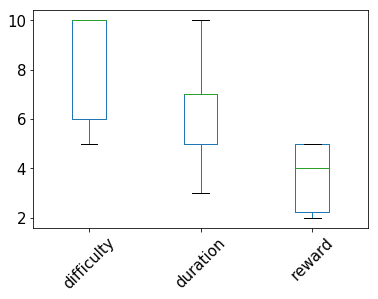

In [52]:
portfolio.boxplot(grid=False, rot=45, fontsize=15)  

There are no extreme values for difficulty and reward.

##### B. Customers dataframe

In [53]:
profile.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


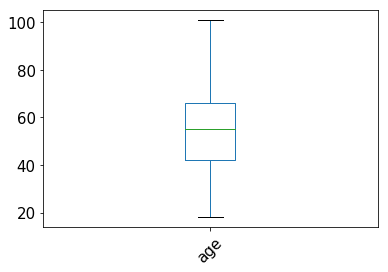

In [54]:
profile.boxplot(['age'],grid=False, rot=45, fontsize=15)  

In [189]:
extrem_val('age',profile)

After droping extreme values from the age columns the average age decrease from 63 to 59 years. 

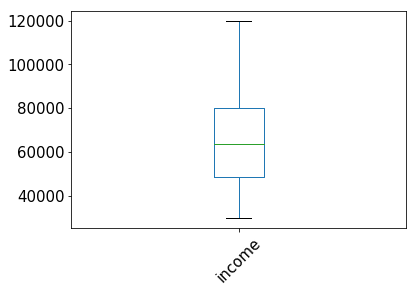

In [56]:
profile.boxplot(['income'],grid=False, rot=45, fontsize=15)  

There are no extreme values for income.

##### C. Events dataframe

In [58]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


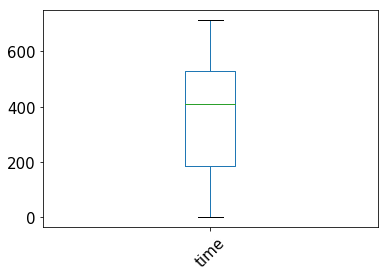

In [59]:
transcript.boxplot(grid=False, rot=45, fontsize=15)  

There are no extreme values for time.

### Format data

##### A. Offers dataframe

In [60]:
portfolio.head(2)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10.0,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,NaN
1,"[web, email, mobile, social]",10.0,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,NaN


In [61]:
#portfolio dataframe data types 
portfolio.dtypes

channels       object
difficulty    float64
duration        int64
id             object
offer_type     object
reward        float64
dtype: object

In [190]:
#create dummy variables
#https://stackoverflow.com/questions/66940757/pandas-list-in-column-to-binary-column

def dummy_split(var, df, sep):
    df_split = df[var].str.join(sep).str.get_dummies() 
    #df_new = pd.concat([df, df_split], axis=1)
    return df_split

def concat_df(df, df_split):
    df_new = pd.concat([df, df_split], axis=1)
    return df_new

In [191]:
#create dummy variables based on channels column 
df_channels = dummy_split('channels', portfolio, '|')
df_channels.head(2)

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1


In [192]:
#create dummy variables based on offer_type column 
df_offer_type = dummy_split('offer_type', portfolio, '')
df_offer_type.head(2)

,bogo,discount,informational
0,1,0,0
1,1,0,0


In [193]:
#concatenate df 
portfolio = concat_df(concat_df(portfolio, df_channels),df_offer_type)
portfolio.head(2)

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10.0,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,NaN,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10.0,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,NaN,1,1,1,1,1,0,0


##### B. Customers dataframe

In [66]:
profile.head(2)

,age,became_member_on,gender,id,income
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,NaN,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0


In [67]:
#profile dataframe data types 
print(profile.dtypes)

age                 float64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object


In [194]:
# converting the string to datetime format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['became_member_on'].head(5)

1    2017-07-15
3    2017-05-09
5    2018-04-26
8    2018-02-09
12   2017-11-11
Name: became_member_on, dtype: datetime64[ns]

##### C. Events dataframe

In [69]:
transcript.head(2)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [70]:
#transcript dataframe data types 
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

In [195]:
#create dummy variables based on event column 
df_event = dummy_split('event', transcript, '')
transcript = concat_df(transcript, df_event)
transcript.head(2)

,event,person,time,value,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0


In [196]:
#https://stackoverflow.com/questions/35711059/extract-dictionary-value-from-column-in-data-frame
def dict_split(var, index, new_var, df):
    df[new_var] = transcript[var].apply(lambda x: x.get(index))
    return df

dict_split('value', 'offer id', 'offer_id', transcript)
dict_split('value', 'amount', 'amount', transcript)

transcript.head(2)

,event,person,time,value,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


### Test for duplicate values

In [73]:
portfolio.loc[:, ~portfolio.columns.isin(['channels'])].duplicated().sum()

0

In [74]:
profile.duplicated().sum()

0

In [75]:
#testing for duplicates values 
transcript.loc[:, ~transcript.columns.isin(['value'])].duplicated().sum()

2962

In [76]:
transcript.head(2)

,event,person,time,value,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [197]:
transcript = transcript.drop_duplicates(subset=['event', 'person', 'time', 'offer completed', 'offer received', 'offer viewed', 'transaction', 'offer_id', 'amount'], keep='last')

In [198]:
transcript.loc[:, ~transcript.columns.isin(['value'])].duplicated().sum()

0

### Create auxiliary variables

##### B. Customers dataframe

In [199]:
#create month and year column from the data a customer has become member
profile['member_year'] = pd.DatetimeIndex(profile['became_member_on']).year
profile['member_month'] = pd.DatetimeIndex(profile['became_member_on']).month
profile.head(2)

,age,became_member_on,gender,id,income,member_year,member_month
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,NaN,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5


In [50]:
profile['member_year'].unique()

array([2017, 2018, 2014, 2016, 2013, 2015])

In [18]:
(profile['member_year'].value_counts()/profile['member_year'].value_counts().sum())*100

2017    37.767285
2018    24.748735
2016    20.397976
2015    10.772344
2014     4.465430
2013     1.848229
Name: member_year, dtype: float64

The majority of events are registered in the 2016-2018 timeline.

In [20]:
profile.head(2)

,age,became_member_on,gender,customer_id,income,member_year,member_month
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5


##### B. Events dataframe

In [200]:
transcript['days'] = (transcript['time']/24).round()
transcript.head(2)

,event,person,time,value,offer completed,offer received,offer viewed,transaction,offer_id,amount,days
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0.0


#### Merge databases

In [201]:
portfolio = portfolio.rename(columns={"id": "offer_id"})

In [19]:
portfolio.head(2)

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10.0,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,NaN,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10.0,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,NaN,1,1,1,1,1,0,0


In [202]:
profile = profile.rename(columns={"id": "customer_id"})

In [88]:
profile.head(2)

,age,became_member_on,gender,customer_id,income,member_year,member_month
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,NaN,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5


In [203]:
transcript = transcript.rename(columns={"person": "customer_id", "offer completed":"offer_completed", "offer received":"offer_received","offer viewed":"offer_viewed" })

In [90]:
transcript.head(2)

,event,customer_id,time,value,offer_completed,offer_received,offer_viewed,transaction,offer_id,amount,days
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0.0


In [204]:
# Merge datasets 
df = transcript.merge(portfolio, on=['offer_id'], how='left')
df = df.merge(profile, on=['customer_id'], how='left')
df.head()

,event,customer_id,time,value,offer_completed,offer_received,offer_viewed,transaction,offer_id,amount,...,web,bogo,discount,informational,age,became_member_on,gender,income,member_year,member_month
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,1.0,1.0,0.0,0.0,NaN,2017-05-09,F,100000.0,2017.0,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,...,1.0,0.0,1.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,...,1.0,0.0,1.0,0.0,NaN,2018-04-26,M,70000.0,2018.0,4.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,...,1.0,0.0,1.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,...,1.0,1.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN


In [205]:
df.shape

(303572, 29)

### 4. Modeling

Trying to reproduce patterns from customers experience and Starbucks market offers, I choose to use different visualizations to better understand the data, but also different statistical models for binary and numeric variables:
* Random Tree Classification model
* Logistic regression model
* Regression model

#### What are the main variables that influence the decision of a customer to respond to an offer?

In order to understand the factors that may influence a transaction I have taken into consideration the type of offer: bogo, discount, informational and the channel: email, mobile, social and web. 

In [239]:
df_log = df[['transaction', 'bogo', 'discount', 'informational', 'email', 'mobile', 'social', 'web']]
#replace na from transaction with 0 - no transaction
df_log['transaction'] = df_log['transaction'].fillna(0)
#replacing na with another category: 2
df_log = df_log.fillna(2)
df_log['transaction'].unique()

array([0, 1])

In [240]:
X = df_log[['bogo', 'discount', 'informational', 'email', 'mobile', 'social', 'web']]
y = df_log[['transaction']]

#### Random Forest Classification

In [231]:
pipeline = Pipeline([
        ('feature_selection', SelectKBest(chi2, k=2)),
        ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=0)))
    ])
pipeline.get_params()

{'memory': None,
 'steps': [('feature_selection',
   SelectKBest(k=2, score_func=<function chi2 at 0x7f670078eb70>)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=0, verbose=0, warm_start=False),
              n_jobs=1))],
 'feature_selection': SelectKBest(k=2, score_func=<function chi2 at 0x7f670078eb70>),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split

In [232]:
# Creation the train and test sets for the independent and dependent variables dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(y_pred)

[[0]
 [1]
 [1]
 ..., 
 [1]
 [0]
 [1]]


##### Metrics

Next, I used the model predictions to discover the model power.

In [233]:
accuracy = (y_pred == y_test).mean()
print('The calculated accuracy is:', accuracy[0])

The calculated accuracy is: 0.900189409536


This model accuracy is valued at 0.9, meaning that the model actually correctly predicts 90% of its classifications over the transaction variable.

In [234]:
print(classification_report(y_test, y_pred, target_names =y.columns)) 

             precision    recall  f1-score   support

transaction       1.00      0.82      0.90     32934

avg / total       0.92      0.90      0.90     60715



Using the chosen metrics I could discover that 92% of the positive classifications have been correctly predicted and 90% of total positive are predicted positive. F score takes into consideration both precision and recall, proving the power of the model with a value of 0.9.

In [235]:
#confusion matrix
confus_matrix = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix: ')
print(confus_matrix)

Confusion matrix: 
[[26874  6060]
 [    0 27781]]


Text(0.5,257.44,'Predicted label')

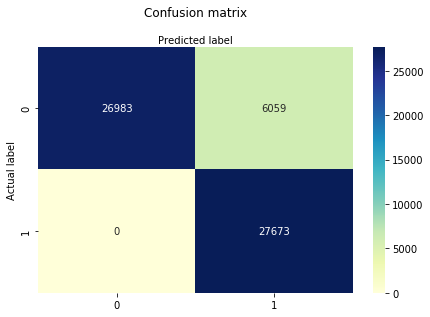

In [213]:
#source:https://www.datacamp.com/tutorial/understanding-logistic-regression-python
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confus_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Accordingly to the confusion matrix there were 27673 transactions and 26983 events without transaction (predicted as the actual value), but also 6059 have been wrongly predicted as transaction and on the other hand none of the transactions have been predicted as non-transactions.

##### Tunning

Next step will be to optimize the random forest model obtained above.

In [236]:
parameters = {
        'clf__estimator__n_estimators': [50, 100, 200],
        'clf__estimator__min_samples_split': [2, 3, 4]
    }
parameters

{'clf__estimator__n_estimators': [50, 100, 200],
 'clf__estimator__min_samples_split': [2, 3, 4]}

In [237]:
cv = GridSearchCV(pipeline, param_grid=parameters)
cv

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_selection', SelectKBest(k=2, score_func=<function chi2 at 0x7f670078eb70>)), ('clf', MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impu...1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__estimator__n_estimators': [50, 100, 200], 'clf__estimator__min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [238]:
cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_selection', SelectKBest(k=2, score_func=<function chi2 at 0x7f670078eb70>)), ('clf', MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impu...1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__estimator__n_estimators': [50, 100, 200], 'clf__estimator__min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [217]:
y_pred = cv.predict(X_test)
y_pred

array([[0],
       [0],
       [0],
       ..., 
       [0],
       [1],
       [0]])

In [218]:
print(classification_report(y_test, y_pred, target_names =y.columns))

             precision    recall  f1-score   support

transaction       1.00      0.82      0.90     33042

avg / total       0.92      0.90      0.90     60715



In [219]:
accuracy = (y_pred == y_test).mean()
print("The calculated accuracy is :", accuracy[0])

The calculated accuracy is : 0.900205879931


After optimizing the model we can not conclude that there is any improvement in the model performance.

#### Logistic regression model

In [243]:
#source:https://www.datacamp.com/tutorial/understanding-logistic-regression-python
# create training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
# Logistic regression model
model = LogisticRegression()
# fit the model
model.fit(X_train,y_train)
#compute predictions
y_pred=model.predict(X_test)
print('Predicted transactions:', y_pred)

Predicted transactions: [1 1 1 ..., 0 1 1]


In [244]:
print("The r-squared score for the model is {} for {} values.".format(r2_score(y_test, y_pred), len(y_test)))
print('Regression model coefficients:')
print( model.coef_)
print('Regression model intercept:')
print(model.intercept_)

The r-squared score for the model is 0.5915988362690818 for 75893 values.
Regression model coefficients:
[[ 3.23171157  2.91376769  3.83529341 -3.52717916 -1.9933263   0.24027638
  -0.4918476 ]]
Regression model intercept:
[-6.90416711]


The regression model explains 59.16% of the variance associated with the dependent variable, the model being good. 
Accordingly to the coefficients there is a more change to have a transaction is an offer is informational or bogo and less for  discount, but also if an offer is social.

##### Metrics

In [245]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.898580896789


The logistic regression model presents a good accuracy of 89.85%. 

In [246]:
print(classification_report(y_test, y_pred, target_names =y.columns)) 

             precision    recall  f1-score   support

transaction       1.00      0.81      0.90     41046

avg / total       0.92      0.90      0.90     75893



For the second model the values are similar, 92% of the positive classifications being correctly predicted and 90% of total positive being predicted positive. F score takes has also a value of 0.9.

In [247]:
#confusion matrix
confus_matrix = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix: ')
print(confus_matrix)

Confusion matrix: 
[[33349  7697]
 [    0 34847]]


Text(0.5,257.44,'Predicted label')

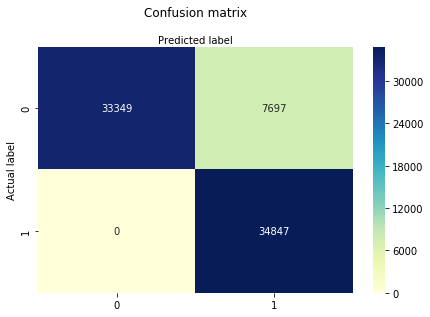

In [248]:
#source:https://www.datacamp.com/tutorial/understanding-logistic-regression-python
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confus_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Accordingly to the confusion matrix there were 34847 transactions and 33349 events without transaction  (predicted as the actual value), but also 7697 have been wrongly predicted as transaction and on the other hand none of the transactions have been predicted as non-transactions.

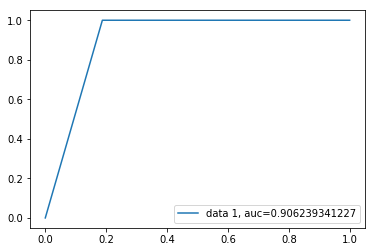

In [249]:
#source:https://www.datacamp.com/tutorial/understanding-logistic-regression-python
y_pred_pr = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_pr)
auc = metrics.roc_auc_score(y_test, y_pred_pr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

The ROC curve shows the performance of the model, at a level of 0.9. 

#### Can we predict how much someone will spend based on customer characteristics and offer eligibility?

#### Regression model 

In order to predict the amount spend on a transaction I took into consideration the customer income, age and the time since the event started. 

In [250]:
df_trans = df[['amount','age', 'income', 'time']]
df_trans = df_trans.dropna(subset = ['amount', 'age', 'income', 'time'])
X = df_trans[['age', 'income', 'time']]
y = df_trans['amount']

In [251]:
def regression_model(X, y):
    
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=13)
    
    #Create the model
    lm_model = LinearRegression(normalize=True)
    
    #Fitt the model
    lm_model.fit(X_train, y_train) 
    
    #Predict and score the model    
    y_test_preds = lm_model.predict(X_test)
    
    print("The r-squared score for your model is {} for {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))
    print('Regression model coefficients:')
    print( lm_model.coef_)
    print('Regression model intercept:')
    print(lm_model.intercept_)

##### Metrics

In [252]:
regression_model(X, y)

The r-squared score for your model is 0.05586567838007983 for 18029 values.
Regression model coefficients:
[ 0.04219896  0.00037299  0.0009592 ]
Regression model intercept:
-11.3189352739


The regression model explains a very small variance of the dependent variable, amount, only 5% meaning that the model is not that strong. 
If we are looking at the coefficients, we can state that an increase in age has the biggest impact in increasing the amount spend on a transaction, followed by a very small positive influence between income and time spend on transaction.

### 5. Results

The Starbucks reward mobile app data analysis determined that:
* the bogo and discount offers are considered the most appealing by customers, having a bigger proportion in the offer pool
* Starbucks has by now offered reward up to 10 monetary units, the biggest rewards being attributed to bogo offers
* although discount and bogo offers are the most appreciated , those ones impose the biggest time to complete and also a great difficulty
* Starbucks prefers mostly using email and mobile channels, but also social and web
* the minimum age required in order to be a member is 18 years
* most of the customers are men (almost 50%) with the largest average income comparative with women
* most of the events are considered finished transactions, but there are a lot of events in with the status received or viewed only
* the average time in completing an offer is 15 days
* using two statistical models, random forest tree classifier and logistic regression, we can appreciate that the customer decision in making a transaction is influenced by the offer type and the channel type
* the model can be used to predict a transaction based on those criteria 
* using the linear regression model I tried to predict the amount spend on a * transaction by customer age and income, but also the time since the offer is received until the transaction
* the biggest influence is the customer age, followed by the time between steps

### 5. Improvements

In the future I would like to improve the models already developed, but also creating an recommendation model in order to know which customer typology better suits a specific offer.